# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
Appliance_subset_df = pd.read_parquet('..\Project Main\data\Appliance_file_subset.parquet', engine='pyarrow')

In [3]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,1619039933066,0,True
1,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,1485195813000,0,True
2,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,AGIOHNK7IWRDNBWYPGETIDTKTJUA,1505914496902,0,True
3,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,1605903535168,0,True
4,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,1645229528359,0,True


In [4]:
print(Appliance_subset_df.shape)

(50000, 10)


In [5]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5918
2.0     1871
3.0     2421
4.0     5024
5.0    34766
Name: count, dtype: int64

## Quick EDA

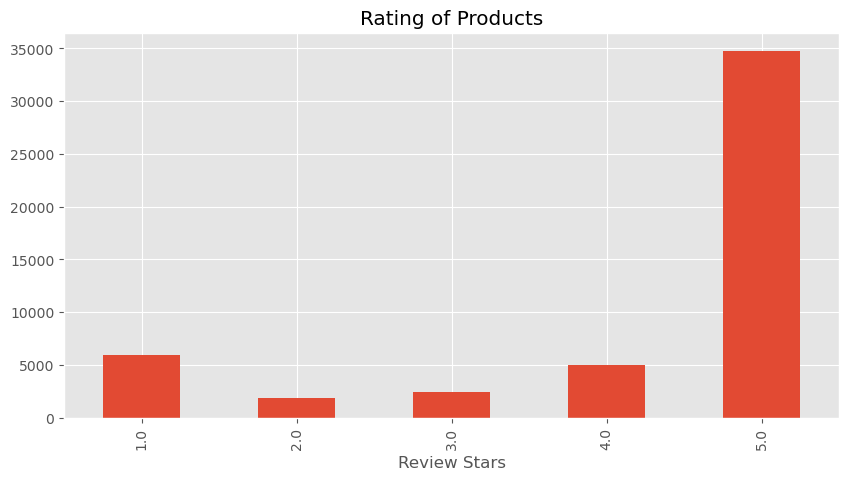

In [6]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [7]:
example = Appliance_subset_df['text'][1989]
print(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Easy',
 'Replacement',
 'Parts',
 'for',
 'Appliances',
 'at',
 'a',
 'Reduced',
 'Price',
 'and',
 'fits',
 'perfect',
 '...']

In [9]:
#part of speech tagging values
tagged = nltk.pos_tag(tokens)
tagged[:]

[('Easy', 'JJ'),
 ('Replacement', 'NNP'),
 ('Parts', 'NNP'),
 ('for', 'IN'),
 ('Appliances', 'NNP'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('Reduced', 'NNP'),
 ('Price', 'NNP'),
 ('and', 'CC'),
 ('fits', 'NNS'),
 ('perfect', 'VBP'),
 ('...', ':')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
#prettyprint

(S
  (PERSON Easy/JJ)
  (ORGANIZATION Replacement/NNP Parts/NNP)
  for/IN
  Appliances/NNP
  at/IN
  a/DT
  (ORGANIZATION Reduced/NNP)
  Price/NNP
  and/CC
  fits/NNS
  perfect/VBP
  .../:)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia

In [13]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [14]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [15]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [16]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [17]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [18]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
results

{'AFJBSFUSBCMWLLXMBZ44ETHRKNOA': {'neg': 0.072,
  'neu': 0.809,
  'pos': 0.118,
  'compound': 0.3818},
 'AGB653QU2TLQPUZ2QX3VNRWFOUKQ': {'neg': 0.0,
  'neu': 0.0,
  'pos': 1.0,
  'compound': 0.6588},
 'AGIOHNK7IWRDNBWYPGETIDTKTJUA': {'neg': 0.0,
  'neu': 0.391,
  'pos': 0.609,
  'compound': 0.7774},
 'AGBTZVKIXMEBARPSYPIQLFH2NYWQ': {'neg': 0.0,
  'neu': 0.58,
  'pos': 0.42,
  'compound': 0.7003},
 'AHKS2IQWTIFWQZTUVP23U2GYLO5Q': {'neg': 0.0,
  'neu': 0.377,
  'pos': 0.623,
  'compound': 0.765},
 'AHY557OHZXZUGKRAB6ZHRONRE26A': {'neg': 0.0,
  'neu': 0.671,
  'pos': 0.329,
  'compound': 0.6597},
 'AGOICXX54S3SREXAOM3BYYN4AZRA': {'neg': 0.082,
  'neu': 0.918,
  'pos': 0.0,
  'compound': -0.395},
 'AHO74DWEGRT3UVGRKG4CCOMTL5BA': {'neg': 0.0,
  'neu': 0.734,
  'pos': 0.266,
  'compound': 0.4404},
 'AH7AGJZSWT5KAEW4OFJIH5DQCUUA': {'neg': 0.042,
  'neu': 0.863,
  'pos': 0.096,
  'compound': 0.9699},
 'AFMZ3YXI2VANHHEXF2LCBCYHFEGA': {'neg': 0.043,
  'neu': 0.803,
  'pos': 0.154,
  'compound': 

In [20]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [21]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [22]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [23]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [24]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,1619039933066,0,True
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,1485195813000,0,True
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,1505914496902,0,True
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,1605903535168,0,True
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,1645229528359,0,True


## Plot VADER results

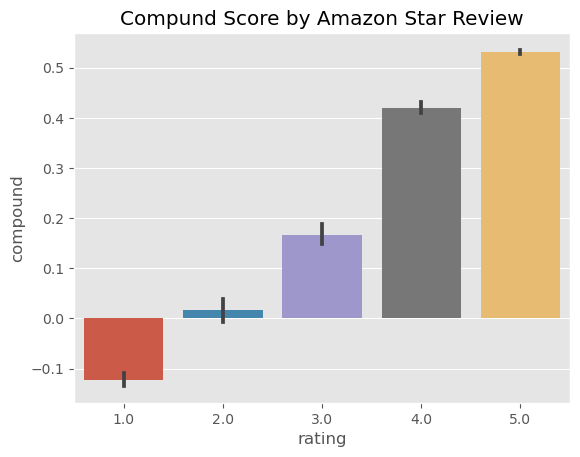

In [25]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

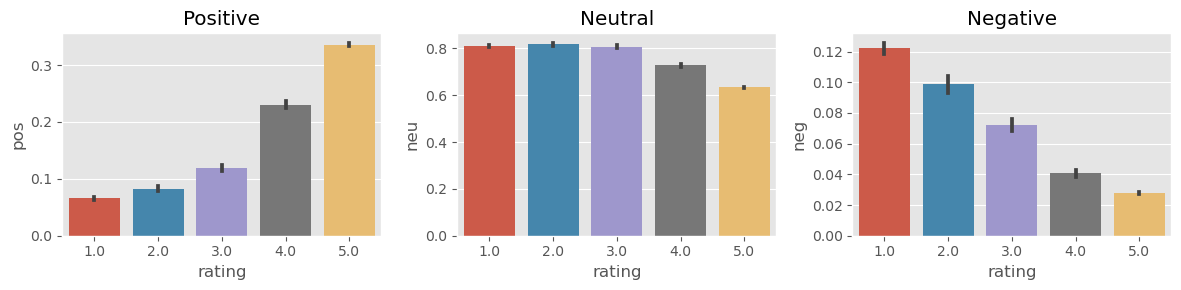

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [27]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [28]:
#pull in a model provided by hugging face pre-trained on a large twitter dataset 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\gisi_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
# Remembering VADER results on example
print(example)
sia.polarity_scores(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [30]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.003501815, 'roberta_neu': 0.095212415, 'roberta_pos': 0.90128577}


In [31]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [32]:
df = Appliance_subset_df.sample(5000)

In [33]:
df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
47591,1.0,Way overpriced and poor quality for genuine GE...,It's been less than a month and I already foun...,[],B00LGUBHJG,B00LGUBHJG,AFAMMZ73KQAYFRVC6CLDXSLTK6VQ,1599862989244,1,True
14044,5.0,Fits over both crisper drawers,Pan cover fits over both drawers. Since crisp...,[],B00545AZ0Q,B00545AZ0Q,AEG7HZGNF74433TWFXAEJ4BMO7WA,1503262868166,0,True


In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        
        
        text = row['text']
        id = row['user_id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id AHUTC3R7TJ54Y23QNAONOYVEOQMA
Broke for id AET5OZD3N6SKOSXEQMM63MH2FRSQ
Broke for id AHQUIGI6K2MJRBO7VPJF55LDLWEQ
Broke for id AGUQJZHE662GL4MY2GLBMA4HZ3IQ
Broke for id AFUAQRE5I2K72ZIYUEFKCUN6RLGQ
Broke for id AGXMFNQWLTFJFZIQS4ORUXCMFTLQ
Broke for id AGUQTJQ6OHKRBSYTT6UQLFS4EZGA
Broke for id AE2DJTM2B5SBQG4GWL4I2K4CLWHA
Broke for id AFFVY5CQZZGGXVWS3Y4M5BXR6VFQ
Broke for id AG4J4PE6PIDDITVVQTTPMPZVQL7A
Broke for id AFAK7BDSYTLBEYR6OQDL5MAF7MUA


In [37]:
results_df = pd.DataFrame(res).T
# results_df = results_df.reset_index().rename(columns={'index': 'Id'})


results_df.index.name = 'user_id'
results_df.head(2)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
user_id,,,,,,,
AFAMMZ73KQAYFRVC6CLDXSLTK6VQ,0.110,0.890,0.0,-0.7351,0.950312,0.04411,0.005579
AEG7HZGNF74433TWFXAEJ4BMO7WA,0.173,0.827,0.0,-0.5574,0.472755,0.44628,0.080965


In [38]:
# Reset the index to turn the index into a column
results_df = results_df.reset_index()
results_df.head()

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,AFAMMZ73KQAYFRVC6CLDXSLTK6VQ,0.110,0.890,0.000,-0.7351,0.950312,0.044110,0.005579
1,AEG7HZGNF74433TWFXAEJ4BMO7WA,0.173,0.827,0.000,-0.5574,0.472755,0.446280,0.080965
2,AEU7OTBNRKMWH3TMB3QHM5MAN57A,0.169,0.605,0.226,0.6318,0.122313,0.279635,0.598052
3,AHPLFV6T55MDM4CZLE7QGMYPYH2Q,0.000,1.000,0.000,0.0000,0.120438,0.704692,0.174870
4,AF3HHVG4MBGAFHQMCIZD2YC5YRTQ,0.000,0.628,0.372,0.9902,0.002736,0.004749,0.992515


## Compare Scores between models

In [39]:
results_df.columns

Index(['user_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3. Combine and compare

In [40]:
results_df = results_df.merge(Appliance_subset_df, how='inner')

In [41]:
results_df.head(2)

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFAMMZ73KQAYFRVC6CLDXSLTK6VQ,0.110,0.890,0.0,-0.7351,0.950312,0.04411,0.005579,1.0,Way overpriced and poor quality for genuine GE...,It's been less than a month and I already foun...,[],B00LGUBHJG,B00LGUBHJG,1599862989244,1,True
1,AEG7HZGNF74433TWFXAEJ4BMO7WA,0.173,0.827,0.0,-0.5574,0.472755,0.44628,0.080965,5.0,Fits over both crisper drawers,Pan cover fits over both drawers. Since crisp...,[],B00545AZ0Q,B00545AZ0Q,1503262868166,0,True


In [43]:
results_df[['vader_neg', 'vader_neu', 'vader_pos', 
            'roberta_neg', 'roberta_neu', 'roberta_pos']] = results_df[
            ['vader_neg', 'vader_neu', 'vader_pos', 
             'roberta_neg', 'roberta_neu', 'roberta_pos']].astype(float)


In [46]:
print(results_df.dtypes)


user_id               object
vader_neg            float64
vader_neu            float64
vader_pos            float64
vader_compound       float64
roberta_neg          float64
roberta_neu          float64
roberta_pos          float64
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object


# __